In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [5]:
cols = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


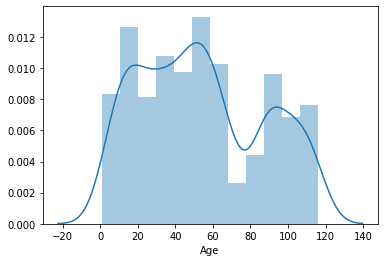

PropertyGFATotal
19.037917545145827


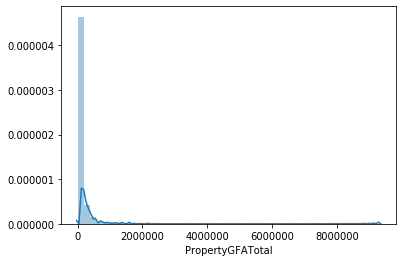

LargestPropertyUseTypeGFA
23.175161728669494


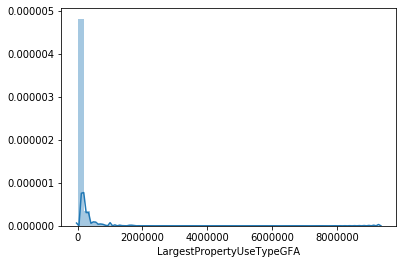

ENERGYSTARScore
-0.7540916788099522


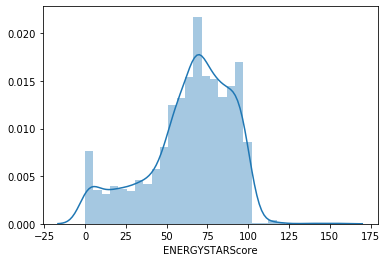

TotalGHGEmissions
14.130656748997303


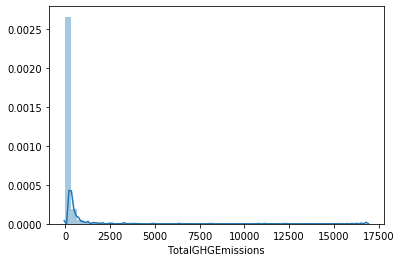

In [6]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [8]:
cols = ['PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

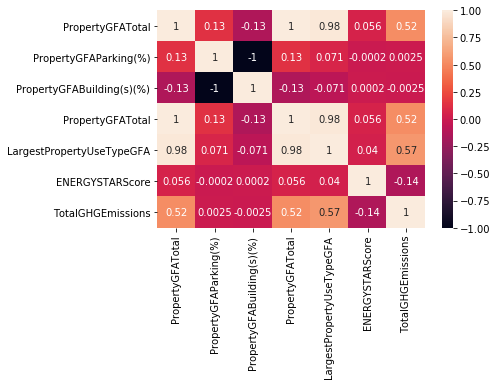

In [9]:
sns.heatmap(data[cols].corr(), annot = True)

In [10]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
colsk = ['NumberofFloors','PropertyGFATotal','LargestPropertyUseTypeGFA']

In [13]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [14]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [15]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [16]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687648486438

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

609.8061505036217

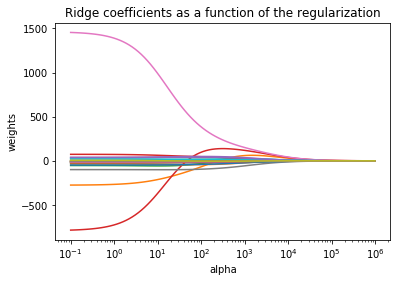

In [18]:
n_alphas = 100
alphas = np.logspace(-1, 6, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

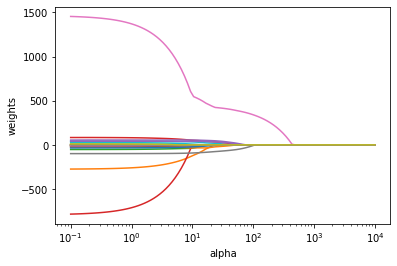

In [19]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [20]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_fit_time', 'mean_test_RMSE', 
    'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 
    'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [21]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [22]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

params  mean_fit_time  mean_test_RMSE  \
8    {'alpha': 885.8667904100823}       0.001196      470.913480   
7   {'alpha': 379.26901907322497}       0.001153      500.934272   
9    {'alpha': 2069.138081114788}       0.001126      511.918295   
10   {'alpha': 4832.930238571752}       0.000927      551.341484   
6    {'alpha': 162.3776739188721}       0.001230      564.999859   

    rank_test_RMSE  mean_test_MSE  rank_test_MSE  mean_test_MAE  \
8                1  386566.905616              1     156.210564   
7                2  401285.250916              2     168.314468   
9                3  424732.723217              3     162.649720   
10               4  474818.581518              4     178.983598   
6                5  505143.271042              5     183.455189   

    rank_test_MAE  mean_test_R2  rank_test_R2  
8               1      0.182423             2  
7               3      0.092046             4  
9               2      0.191583             1  
10              4      0.133483             3  
6               5     -0.085114             7

In [23]:
grid_ridge_best_params ={'alpha': 885.8667904100823}

In [24]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

667.5924071885416

In [25]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

params  mean_fit_time  mean_test_RMSE  \
22   {'alpha': 108.2636733874054}       0.001219      482.034646   
21   {'alpha': 78.80462815669912}       0.001120      485.667801   
20  {'alpha': 57.361525104486816}       0.000923      510.361700   
23  {'alpha': 148.73521072935117}       0.001338      519.463084   
19     {'alpha': 41.753189365604}       0.001344      549.137665   

    rank_test_RMSE  mean_test_MSE  rank_test_MSE  mean_test_MAE  \
22               1  390672.896520              2     166.508118   
21               2  388007.314034              1     160.898091   
20               3  408183.764734              3     159.388906   
23               4  423485.936575              4     174.200005   
19               5  473367.994526              5     164.471367   

    rank_test_MAE  mean_test_R2  rank_test_R2  
22              4      0.161576             2  
21              2      0.166615             1  
20              1      0.134925             4  
23              6      0.142706             3  
19              3      0.057019             6

In [26]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [27]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1883940438229

In [28]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

"tt_ridge = TransformedTargetRegressor(regressor = Ridge(),\n                               func = np.log1p,\n                               inverse_func = np.expm1)\nparams = {'regressor__alpha': np.logspace(0, 7, 100)}\ngrid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)\ngrid_tt_ridge.fit(X_train_tt, y_train)\ngrid_tt_ridge_best_params = grid_tt_ridge.best_params_\nresultize(grid_tt_ridge).head()"

In [29]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [30]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

669.919863276771

In [31]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

params  mean_fit_time  mean_test_RMSE  \
1   {'regressor__alpha': 0.1373823795883263}       0.001438      488.610469   
0                  {'regressor__alpha': 0.1}       0.001783      509.880646   
2  {'regressor__alpha': 0.18873918221350972}       0.001340      525.028792   
3   {'regressor__alpha': 0.2592943797404667}       0.001304      567.895018   
4   {'regressor__alpha': 0.3562247890262442}       0.001274      595.499456   

   rank_test_RMSE  mean_test_MSE  rank_test_MSE  mean_test_MAE  rank_test_MAE  \
1               1  420607.282556              1     126.617853              1   
0               2  430272.551358              2     127.016252              2   
2               3  449586.600941              3     134.195058              3   
3               4  500137.269016              4     141.643945              4   
4               5  541592.650961              5     147.327352              5   

   mean_test_R2  rank_test_R2  
1      0.304148             2  
0      0.314066             1  
2      0.242017             3  
3      0.155993             4  
4      0.082779             5

In [32]:
grid_tt_lasso_best_params = {'alpha':0.1373823795883263}

In [33]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

704.4578508292199

In [34]:
"""params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()"""

"params = {'kernel': ['sigmoid','rbf','poly'],\n         'C': [0.1,1,100,1000],\n         'degree': [1,2,3,4,5,6]}\ngrid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,\n                        refit = score,  n_jobs=-1)\ngrid_svr.fit(X_train, y_train)\nbest_params_svr = grid_svr.best_params_\nresultize(grid_svr).head()"

In [35]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [36]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

681.2704119337739

In [37]:
"""tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()"""

"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6]}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train_tt, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [38]:
best_params_svr_tt = {'C': 1, 'degree': 6}

In [39]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

523.5468944912827

In [40]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'max_depth': [1,3,5,7,9],\n            'min_samples_split': [3,5,7,9],\n}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [41]:
best_params_rf = {'max_depth': 9, 'min_samples_split': 9, 'n_estimators': 100}

In [42]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

374.468494510763

In [43]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

"tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__max_depth': [1,3,5,7,9],\n            'regressor__min_samples_split': [3,5,7,9]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train_tt, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [44]:
best_params_rf_tt = {'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200}

In [45]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

374.37596640773586

In [46]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [47]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 5}

In [48]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

431.3419966136815

In [49]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

"tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [50]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [51]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

204.1456126426528

In [52]:
'''params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

"params = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'loss': ['linear', 'square', 'exponential'],\n}\ngrid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_ad.fit(X_train, y_train)\nbest_params_ad = grid_ad.best_params_\nresultize(grid_ad).head()"

In [53]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [54]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

391.69807298031753

In [55]:
'''tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

"tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train_tt, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [56]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'linear',
      'n_estimators': 200
      }

In [57]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

542.6355505594958

In [58]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

"params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [59]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [60]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

672.3005370685665

In [61]:
'''tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()'''
#1m20s

"tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_tt_mlp = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [62]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [63]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

549.5916992183066

In [64]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [65]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [66]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

281.2642117282636

In [67]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

"tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt, y_train)\nbest_params_tt_xgb = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [68]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [69]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

254.5876258922429

In [70]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [71]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

Model        RMSE
11  Gradient Boosting_tt  204.145613
17            XGBoost_tt  254.587626
16               XGBoost  281.264212
9       Random Forest_tt  374.375966
8          Random Forest  374.468495
12              AdaBoost  391.698073
10     Gradient Boosting  431.341997
7                 SVR_tt  523.546894
13           AdaBoost_tt  542.635551
15                MLP_tt  549.591699
1      Linear Regression  609.806151
2                  Ridge  667.592407
3               Ridge_tt  669.919863
14                   MLP  672.300537
4                  Lasso  681.188394
6                    SVR  681.270412
5               Lasso_tt  704.457851
0               Baseline  770.568765

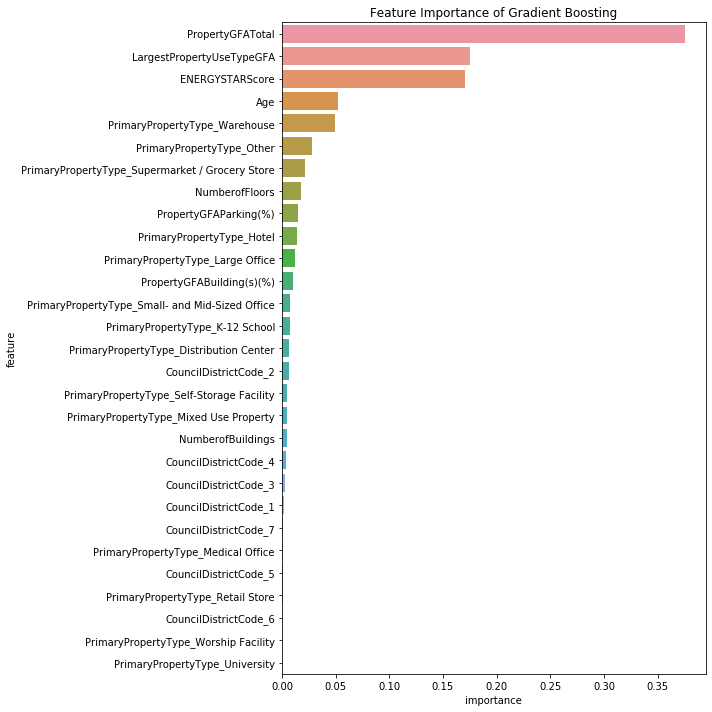

In [90]:
#feature importance of gradient boosting tt
feat_imp_gb_tt = pd.DataFrame({'importance': gb_tt.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_gb_tt)
plt.title('Feature Importance of Gradient Boosting')
plt.tight_layout()
plt.show()

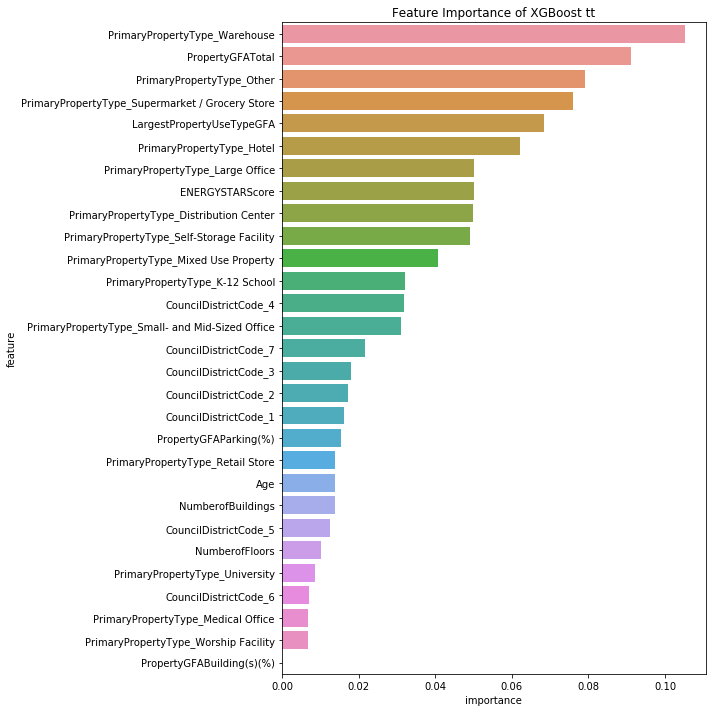

In [89]:
#feature importance of xgboost tt
feat_imp_xgb_tt = pd.DataFrame({'importance': tt_xgb.regressor_.feature_importances_})
feat_imp_xgb_tt['feature'] = X_train.columns
feat_imp_xgb_tt = feat_imp_xgb_tt.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_xgb_tt)
plt.title('Feature Importance of XGBoost tt')
plt.tight_layout()
plt.show()

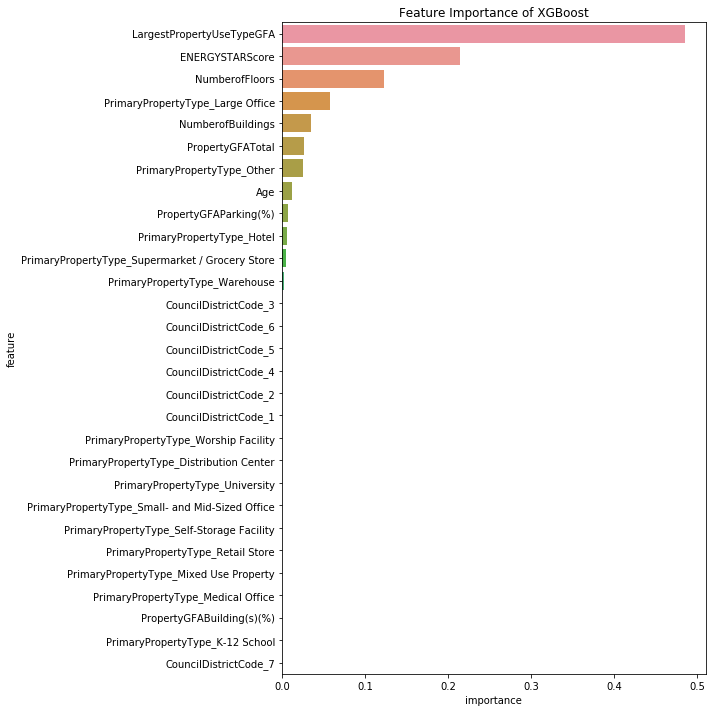

In [88]:
#feature importance of xgboost
feat_imp_xgb = pd.DataFrame({'importance': xgb.feature_importances_})
feat_imp_xgb['feature'] = X_train.columns
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_xgb)
plt.title('Feature Importance of XGBoost')
plt.tight_layout()
plt.show()

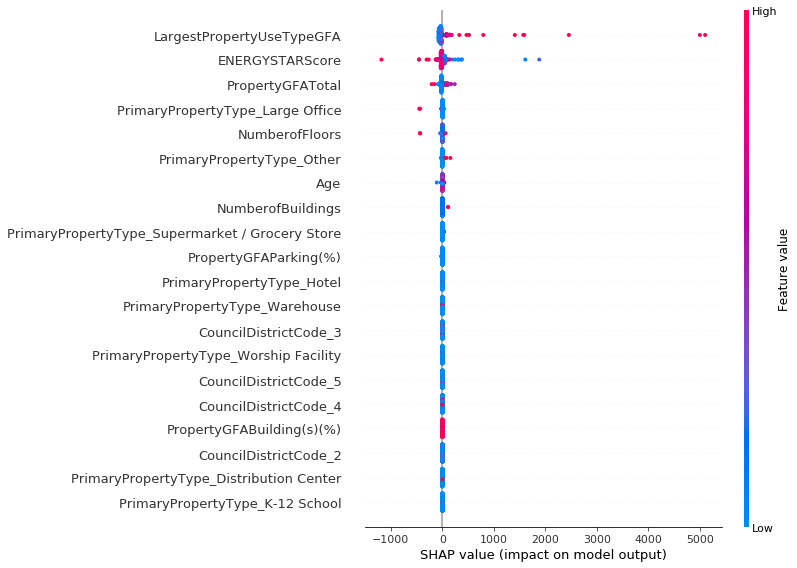

In [76]:
explainer = shap.TreeExplainer(xgb, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test)

In [77]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

feature  importance
3                                  PropertyGFATotal    0.398407
7                                   ENERGYSTARScore    0.173125
6                         LargestPropertyUseTypeGFA    0.146782
0                                               Age    0.042590
18  PrimaryPropertyType_Supermarket / Grocery Store    0.041834
14                        PrimaryPropertyType_Other    0.039582
2                                    NumberofFloors    0.027899
11                 PrimaryPropertyType_Large Office    0.024143
20                    PrimaryPropertyType_Warehouse    0.021775
4                             PropertyGFAParking(%)    0.019864
9                         PrimaryPropertyType_Hotel    0.016854
5                         PropertyGFABuilding(s)(%)    0.011542
1                                 NumberofBuildings    0.007103
23                            CouncilDistrictCode_2    0.006741
13           PrimaryPropertyType_Mixed Use Property    0.005007
8           PrimaryPropertyType_Distribution Center    0.002688
10                  PrimaryPropertyType_K-12 School    0.002644
28                            CouncilDistrictCode_7    0.002624
24                            CouncilDistrictCode_3    0.002435
25                            CouncilDistrictCode_4    0.002409
17  PrimaryPropertyType_Small- and Mid-Sized Office    0.001128
27                            CouncilDistrictCode_6    0.000870
16        PrimaryPropertyType_Self-Storage Facility    0.000443
22                            CouncilDistrictCode_1    0.000431
19                   PrimaryPropertyType_University    0.000405
26                            CouncilDistrictCode_5    0.000382
15                 PrimaryPropertyType_Retail Store    0.000168
12               PrimaryPropertyType_Medical Office    0.000125
21             PrimaryPropertyType_Worship Facility    0.000000

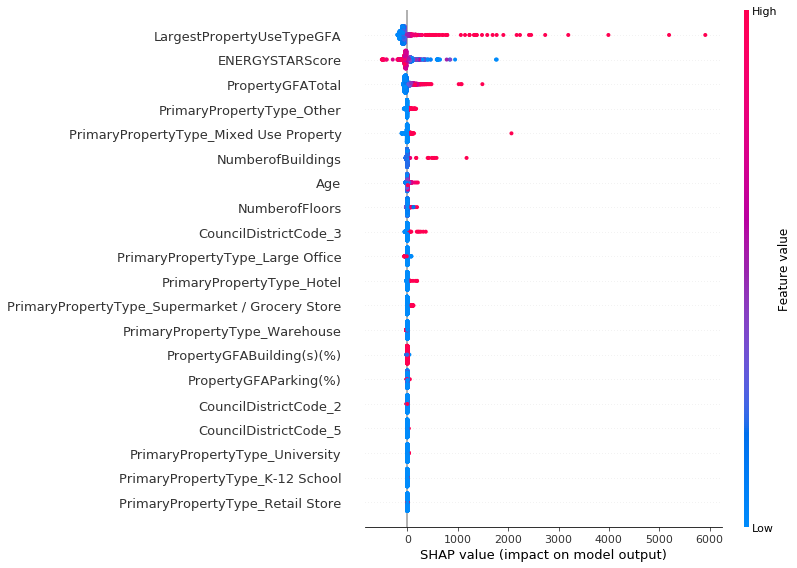

In [78]:
explainer = shap.TreeExplainer(rf)
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

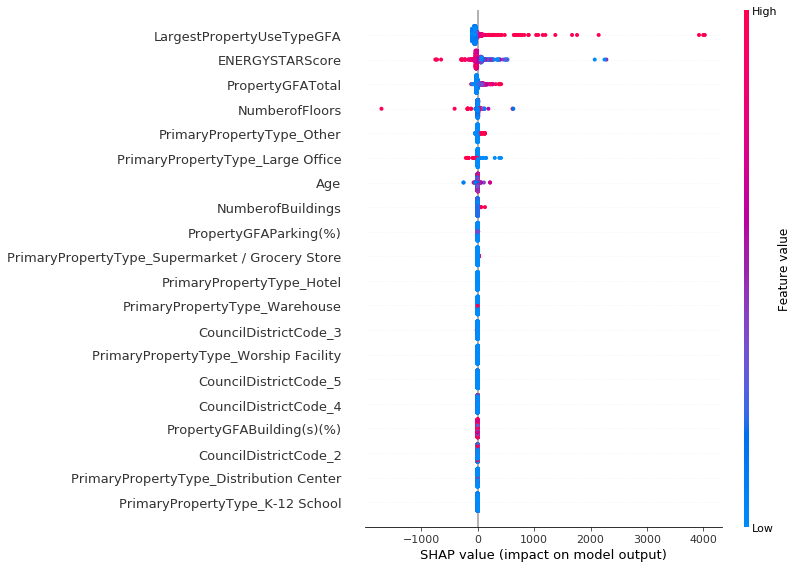

In [79]:
explainer = shap.TreeExplainer(xgb)
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [80]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
i=0
shap.force_plot(explainer.expected_value, shap_values[i], 
                X_train.values[i], feature_names=X_train.columns)

In [81]:
shap.force_plot(explainer.expected_value, shap_values, 
                X_train.values, feature_names=X_train.columns)

In [82]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap.force_plot(explainer.expected_value, shap_values, 
                X_train.values, feature_names=X_train.columns)

In [83]:
X_train_tt_drop_ESS = X_train_tt.drop(['ENERGYSTARScore', 'EnergyStarNaN'], axis=1)
X_test_tt_drop_ESS = X_test_tt.drop(['ENERGYSTARScore', 'EnergyStarNaN'], axis=1)

KeyError: "['EnergyStarNaN'] not found in axis"

In [ ]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt_drop_ESS, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""

"tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt_drop_ESS, y_train)\nbest_params_tt_xgb = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [ ]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [ ]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt_drop_ESS, y_train)
y_pred = tt_xgb.predict(X_test_tt_drop_ESS)
tt_xgb_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error_ESS

440.30702245767503

In [ ]:
tt_xgb_error 

254.5876258922429

In [ ]:
X_train_drop_ESS = X_train.drop(['ENERGYSTARScore', 'EnergyStarNaN'], axis=1)
X_test_drop_ESS = X_test.drop(['ENERGYSTARScore', 'EnergyStarNaN'], axis=1)

In [ ]:
"""ad_ESS = AdaBoostRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential']}
grid = GridSearchCV(ad_ESS, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid.fit(X_train_drop_ESS, y_train)
best_params_ad_ESS = grid.best_params_
resultize(grid).head()"""

params  mean_fit_time  \
8   {'learning_rate': 0.05, 'loss': 'square', 'n_e...       0.668896   
9   {'learning_rate': 0.05, 'loss': 'square', 'n_e...       0.847474   
7   {'learning_rate': 0.05, 'loss': 'square', 'n_e...       0.531849   
33  {'learning_rate': 0.01, 'loss': 'linear', 'n_e...       0.833601   
16  {'learning_rate': 0.02, 'loss': 'linear', 'n_e...       0.404369   

    mean_test_RMSE  rank_test_RMSE  mean_test_MSE  rank_test_MSE  \
8       599.819120               1  535100.678734              1   
9       602.816596               2  539845.505088              2   
7       603.982688               3  544824.552957              3   
33      612.752725               4  566924.050392              4   
16      616.914676               5  575645.343278              5   

    mean_test_MAE  rank_test_MAE  mean_test_R2  rank_test_R2  
8      189.069038             22     -0.748523            38  
9      192.889821             31     -0.678115            31  
7      186.048711             18     -0.566291            21  
33     184.469809             11     -0.390949             3  
16     185.576991             15     -0.391927             4

In [ ]:
best_params_ad_ESS = {'learning_rate': 0.05, 'loss': 'square', 'n_estimators': 400}

In [ ]:
ad_ESS = AdaBoostRegressor(**best_params_ad_ESS)
ad_ESS.fit(X_train_drop_ESS, y_train)
y_pred = ad_ESS.predict(X_test_drop_ESS)
ad_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
ad_error_ESS

527.0093098030825

In [ ]:
ad_error

328.17323413642913

In [ ]:
"""tt_gb_ESS = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_gb = GridSearchCV(tt_gb_ESS, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt_drop_ESS, y_train)
best_params_tt_gb_ESS = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()"""

params  mean_fit_time  \
11  {'regressor__learning_rate': 0.05, 'regressor_...       0.303027   
12  {'regressor__learning_rate': 0.05, 'regressor_...       0.497347   
39  {'regressor__learning_rate': 0.02, 'regressor_...       0.830936   
7   {'regressor__learning_rate': 0.05, 'regressor_...       0.376592   
23  {'regressor__learning_rate': 0.05, 'regressor_...       1.043715   

    mean_test_RMSE  rank_test_RMSE  mean_test_MSE  rank_test_MSE  \
11      449.645772               1  342946.558182              2   
12      452.078941               2  342184.499065              1   
39      452.651252               3  347911.769337              4   
7       453.820815               4  354974.664870              7   
23      454.564152               5  347700.091187              3   

    mean_test_MAE  rank_test_MAE  mean_test_R2  rank_test_R2  
11     119.293786              5      0.437187             6  
12     120.349278             15      0.399638            34  
39     119.476419              8      0.425799            18  
7      117.782556              1      0.400768            33  
23     123.184095             36      0.427299            14

In [ ]:
best_params_tt_gb_ESS = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}

In [ ]:
tt_gb_ESS = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_tt_gb_ESS),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_gb_ESS.fit(X_train_tt_drop_ESS, y_train)
y_pred = tt_gb_ESS.predict(X_test_tt_drop_ESS)
tt_gb_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error_ESS

437.6701540564558

In [ ]:
tt_gb_error

188.62630088505097